In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [3]:
import os
os.environ['CUDA_DEVICES_VISIBLE']='0,1'

In [4]:
cd "/root/SymmNeRF-baseline/code"

/root/SymmNeRF-baseline/code


In [5]:
from opt import config_parser

parser = config_parser()
args = parser.parse_args()

device = 'cuda:1'
args.num_local_layers = 2
args.local_rank = 1
args.no_load_opt = True
args.no_load_scheduler = True
args.local_feature_ch = 1024

det = args.det
lindisp = args.lindisp

In [6]:
from datasets import dataset_dict, create_training_dataset
from torch.utils.data import DataLoader 

from model import model_dict  
from model.sample_ray import RaySampler 
from model.render_ray import render_rays

from utils_lab_fct import * 

import setproctitle
import torch 
import numpy as np 
import tqdm 
import cv2
from einops import rearrange 
import matplotlib.pyplot as plt
from time import time
import multiprocessing as mp

setproctitle.setproctitle('[Gaetan - Check Cosine infl.]')

### Build up a DataLoader 

In [7]:
bs = 3

train_dataset, train_sampler = create_training_dataset(args)
train_loader = DataLoader(train_dataset,batch_size = bs , sampler = train_sampler)

it = iter(train_loader)
train_batch = next(it)

[Info] Training dataset: srns_dataset
[Info] Loading SRNs dataset: /data/srn_cars/cars_train


### Load the model 

##### Baseline model. 

In [8]:
args.cosine_mod = {"use":False,"learn_through_hypernetwork":False,"G": 16}
model = model_dict['hypernerf_symm_local'](args,ckpts_folder = "/data/SymmNeRF-improved/logs/srns_dataset/cars/baseline/ckpts")

[Info] Reloading from /data/SymmNeRF-improved/logs/srns_dataset/cars/baseline/ckpts/model_300000.pth, starting at step=300000


##### Cosine sim. model. G= 8 

In [9]:
args.cosine_mod = {"use":True,"learn_through_hypernetwork":True,"G": 8}
model_cosineG8 = model_dict['hypernerf_symm_local'](args,ckpts_folder = '/data/SymmNeRF-improved/logs/srns_dataset/cars/cosine_depResNetG8/ckpts')

[Info] Reloading from /data/SymmNeRF-improved/logs/srns_dataset/cars/cosine_depResNetG8/ckpts/model_400000.pth, starting at step=400000


##### Cosine sim. model. G= 16

In [10]:
args.cosine_mod = {"use":True,"learn_through_hypernetwork":True,"G": 16}
model_cosineG16 = model_dict['hypernerf_symm_local'](args,ckpts_folder = '/data/SymmNeRF-improved/logs/srns_dataset/cars/cosine_depResNet/ckpts')

[Info] Reloading from /data/SymmNeRF-improved/logs/srns_dataset/cars/cosine_depResNet/ckpts/model_400000.pth, starting at step=400000


##### Cosine sim. model. G=64

In [11]:
args.cosine_mod = {'use':True,'learn_through_hypernetwork':True,'G':64}
model_cosineG64 = model_dict['hypernerf_symm_local'](args,ckpts_folder = '/data/SymmNeRF-improved/logs/srns_dataset/cars/cosine_depResNetG64/ckpts')

[Info] Reloading from /data/SymmNeRF-improved/logs/srns_dataset/cars/cosine_depResNetG64/ckpts/model_400000.pth, starting at step=400000


### Hyper-parameters. 

In [12]:
## Some constants. 
nb_rays = 256
nb_sampled_points_on_rays = 128

# First 2 dim. of the feature map F 
W_F, H_F = 64, 64

### Create a ray batch 
These two functions create a batch of rays to render (from the target view perspective) 

In [13]:
# RaySampler class instantiation.
ray_sampler = RaySampler(train_batch) 

# Get the corresponding source images and poses.
src_imgs = ray_sampler.src_img     # [B, 3, 128,128]
tgt_imgs = ray_sampler.render_imgs # [B,NV,3,128,128]
poses = ray_sampler.render_poses   # [B, NV, 4, 4 ]

# Build up a batch of ray. 
ray_batch = ray_sampler.random_sample(nb_rays,use_bbox = True,device = device)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Get the latent code from the Source Images. 
The .encode() method encodes the RGB source images. Correspond to the f() network in the main paper. 
Each code is a 256d vector. 

In [14]:
z = model.encode(ray_batch['src_img'])
z_cosineG8 = model_cosineG8.encode(ray_batch['src_img'])
z_cosineG16 = model_cosineG16.encode(ray_batch['src_img'])
z_cosineG64 = model_cosineG64.encode(ray_batch['src_img'])

### Render the rays. 
Considering the rays that were sampled on this batch, render them according to symmetry plane that is defined (points are expressed in the source camera viewpoint). 
Volume rendering is also perfomed as well as a last final step. 

In [15]:
from model.render_ray import sample_along_camera_ray, run_network, raw2outputs
from model.nerf import run_nerf_symm_local
from model.nerf_helpers import *
from utils.general import compute_cosine_simmilarity
rays_o = ray_batch['rays_o']    # [B,256,3]
rays_d = ray_batch['rays_d']    # [B,256,3]
z_near = ray_batch['z_near']
z_far = ray_batch['z_far']

noise = False 

#### 1. Get the 3D points ray, the viewdir and z sampled dist.
pts, viewdirs, z_vals = sample_along_camera_ray(rays_o=rays_o,  # pts : [B,256,64,3] - viewdirs : [B,256,3] - z_vals : [B,256,64]
                                                rays_d=rays_d,
                                                z_near=z_near,
                                                z_far=z_far,
                                                device=device,
                                                N_samples=nb_sampled_points_on_rays,
                                                lindisp=lindisp, 
                                                det=det)

print(z_vals.shape)
print(rays_d.shape)

torch.Size([3, 256, 128])
torch.Size([3, 256, 3])


In [16]:
#### 2. Get the NeRF weights according to the latent code z. 
nerf_fine_layers = model.hypernetwork_fine(z) 
nerf_fine_layers_cosineG8 = model_cosineG8.hypernetwork_fine(z_cosineG8)
nerf_fine_layers_cosineG16 = model_cosineG16.hypernetwork_fine(z_cosineG16)
nerf_fine_layers_cosineG64 = model_cosineG64.hypernetwork_fine(z_cosineG64)



#### 2b. Symmetry matrix.
M = torch.tensor([[-1, 0, 0],
                  [0,1, 0],
                  [0, 0, 1]], dtype=torch.float32).to(pts.device) # The original matrix M. 

### 3. Get a set of feature for experimental purpose ( F feature tensor, uv coordinates etc... ) 
ret_features = model.feature_net.index(pts, 
                                       ray_batch['src_pose'],
                                       ray_batch['intrinsics'], 
                                       ray_batch['image_size'], 
                                       noise)

ret_features_cosineG8 = model_cosineG8.feature_net.index(pts, 
                                       ray_batch['src_pose'],
                                       ray_batch['intrinsics'], 
                                       ray_batch['image_size'], 
                                       noise)

ret_features_cosineG16 = model_cosineG16.feature_net.index(pts, 
                                       ray_batch['src_pose'],
                                       ray_batch['intrinsics'], 
                                       ray_batch['image_size'], 
                                       noise)

ret_features_cosineG64 = model_cosineG64.feature_net.index(pts, 
                                       ray_batch['src_pose'],
                                       ray_batch['intrinsics'], 
                                       ray_batch['image_size'], 
                                       noise)


### 4. Concatenate the original feature with its symmetric. 
local_feature = torch.cat([ret_features['feat'],ret_features['feat_s']],-1)
local_feature_cosineG8 = torch.cat([ret_features_cosineG8['feat'],ret_features_cosineG8['feat_s']],-1)
local_feature_cosineG16 = torch.cat([ret_features_cosineG16['feat'],ret_features_cosineG16['feat_s']],-1)
local_feature_cosineG64 = torch.cat([ret_features_cosineG64['feat'],ret_features_cosineG64['feat_s']],-1)


### 4b. - Compute cosine simmilarity between features. 
csG8 = compute_cosine_simmilarity(ret_features_cosineG8['feat'],ret_features_cosineG8['feat_s'],8)
csG16 = compute_cosine_simmilarity(ret_features_cosineG16['feat'],ret_features_cosineG16['feat_s'],16)
csG64 = compute_cosine_simmilarity(ret_features_cosineG64['feat'],ret_features_cosineG64['feat_s'],64)



### 5. Define the NeRF models (one for each image in the batch since they all have a different latent code z). 
nerf_fine = lambda x: run_nerf_symm_local(x, 
                                          nerf_layers=nerf_fine_layers, 
                                          input_ch=model.input_ch,
                                          input_ch_views=model.input_ch_views,
                                          local_feature_ch=1024,
                                          cosine_mod = {"use":False,"learn_through_hypernetwork":False,"G": None}
                                         )

nerf_fine_cosineG8 = lambda x: run_nerf_symm_local(x, 
                                                 nerf_layers=nerf_fine_layers_cosineG8, 
                                                 input_ch=model_cosineG8.input_ch,
                                                 input_ch_views=model_cosineG8.input_ch_views,
                                                 local_feature_ch=1024,
                                                 cosine_mod = {"use":True,"learn_through_hypernetwork":True,"G": 8,'cs':csG8})

nerf_fine_cosineG16 = lambda x: run_nerf_symm_local(x, 
                                                 nerf_layers=nerf_fine_layers_cosineG16, 
                                                 input_ch=model_cosineG16.input_ch,
                                                 input_ch_views=model_cosineG16.input_ch_views,
                                                 local_feature_ch=1024,
                                                 cosine_mod = {"use":True,"learn_through_hypernetwork":True,"G": 16,'cs':csG16})

nerf_fine_cosineG64 = lambda x: run_nerf_symm_local(x, 
                                                 nerf_layers=nerf_fine_layers_cosineG64, 
                                                 input_ch=model_cosineG16.input_ch,
                                                 input_ch_views=model_cosineG16.input_ch_views,
                                                 local_feature_ch=1024,
                                                 cosine_mod = {"use":True,"learn_through_hypernetwork":True,"G": 64,'cs':csG64})



### 6. Do raw forward pass - rgb and alpha are not normalized correctly - Volume rendering was not performed yet. 
raw_fine = run_network(pts,viewdirs,nerf_fine,model.embed_fn,model.embeddirs_fn,local_feature,{"use":False,"learn_through_hypernetwork":False,"G": None})
raw_fine_cosineG8 = run_network(pts,viewdirs,nerf_fine_cosineG8,model_cosineG8.embed_fn,model_cosineG8.embeddirs_fn,local_feature_cosineG8,{"use":True,"learn_through_hypernetwork":True,"G": 8,'cs':csG8})
raw_fine_cosineG16 = run_network(pts,viewdirs,nerf_fine_cosineG16,model_cosineG16.embed_fn,model_cosineG16.embeddirs_fn,local_feature_cosineG16,{"use":True,"learn_through_hypernetwork":True,"G": 16,'cs':csG16})
raw_fine_cosineG64 = run_network(pts,viewdirs,nerf_fine_cosineG64,model_cosineG64.embed_fn,model_cosineG64.embeddirs_fn,local_feature_cosineG64,{"use":True,"learn_through_hypernetwork":True,"G": 64,'cs':csG64})



### 7. Perform the volume rendering to get proper output value. 
outputs_fine = raw2outputs(raw_fine,z_vals,ray_batch['rays_d'],device = device, raw_noise_std = 0.,white_bkgd = True)
outputs_fine_cosineG8 = raw2outputs(raw_fine_cosineG8,z_vals,ray_batch['rays_d'],device = device, raw_noise_std = 0.,white_bkgd=True)
outputs_fine_cosineG16 = raw2outputs(raw_fine_cosineG16,z_vals,ray_batch['rays_d'],device = device, raw_noise_std = 0.,white_bkgd=True)
outputs_fine_cosineG64 = raw2outputs(raw_fine_cosineG64,z_vals,ray_batch['rays_d'],device = device, raw_noise_std = 0.,white_bkgd=True)



### 8. Get some output for better understanding. 
alpha = outputs_fine['alpha']
weights = outputs_fine['weights']
sig = outputs_fine['sigma']
T = outputs_fine['T']

alpha_cosineG8 = outputs_fine_cosineG8['alpha']
weights_cosineG8 = outputs_fine_cosineG8['weights']
sig_cosineG8 = outputs_fine_cosineG8['sigma']
T_cosineG8 = outputs_fine_cosineG8['T']

alpha_cosineG16 = outputs_fine_cosineG16['alpha']
weights_cosineG16 = outputs_fine_cosineG16['weights']
sig_cosineG16 = outputs_fine_cosineG16['sigma']
T_cosineG16 = outputs_fine_cosineG16['T']

alpha_cosineG64 = outputs_fine_cosineG64['alpha']
weights_cosineG64 = outputs_fine_cosineG64['weights']
sig_cosineG64 = outputs_fine_cosineG64['sigma']
T_cosineG64 = outputs_fine_cosineG64['T']


## 1. Features similarity.  

The primary idea is to understand in which extend the projected feature (and its symmetric counterpart) are closed each other and see how it influence the volume rendering. 

#### 1.1 Retrive the uv coordinates of the rays on F plane, the feature tensor F and corresponding feature.

In [17]:
########## Baseline method. 
uv = torch.reshape(ret_features['uv'],(bs,nb_rays,nb_sampled_points_on_rays,1,2)).squeeze() # uv has its coord in [-1,1]. 
uv_sym = torch.reshape(ret_features['uv_symm'],(bs,nb_rays,nb_sampled_points_on_rays,1,2)).squeeze()

F = model.feature_net.latent # [bs,512,H/2,W/2]

f_uv = torch.reshape(ret_features['feat'], (bs,nb_rays,nb_sampled_points_on_rays,512))          # [bs,Nrays,Npoints,512]
f_uv_sym = torch.reshape(ret_features['feat_s'],(bs,nb_rays,nb_sampled_points_on_rays,512)) # [bs,Nrays,Npoints,512]


######### Cosine simm. constraint. G = 8 
uv_cosineG8 = torch.reshape(ret_features_cosineG8['uv'],(bs,nb_rays,nb_sampled_points_on_rays,1,2)).squeeze() # uv has its coord in [-1,1]. 
uv_sym_cosineG8 = torch.reshape(ret_features_cosineG8['uv_symm'],(bs,nb_rays,nb_sampled_points_on_rays,1,2)).squeeze()

F_cosineG8 = model_cosineG8.feature_net.latent # [bs,512,H/2,W/2]

f_uv_cosineG8 = torch.reshape(ret_features_cosineG8['feat'], (bs,nb_rays,nb_sampled_points_on_rays,512))          # [bs,Nrays,Npoints,512]
f_uv_sym_cosineG8 = torch.reshape(ret_features_cosineG8['feat_s'],(bs,nb_rays,nb_sampled_points_on_rays,512)) # [bs,Nrays,Npoints,512]


######### Cosine simm. constraint. G = 16
uv_cosineG16 = torch.reshape(ret_features_cosineG16['uv'],(bs,nb_rays,nb_sampled_points_on_rays,1,2)).squeeze() # uv has its coord in [-1,1]. 
uv_sym_cosineG16 = torch.reshape(ret_features_cosineG16['uv_symm'],(bs,nb_rays,nb_sampled_points_on_rays,1,2)).squeeze()

F_cosineG16 = model_cosineG16.feature_net.latent # [bs,512,H/2,W/2]

f_uv_cosineG16 = torch.reshape(ret_features_cosineG16['feat'], (bs,nb_rays,nb_sampled_points_on_rays,512))          # [bs,Nrays,Npoints,512]
f_uv_sym_cosineG16 = torch.reshape(ret_features_cosineG16['feat_s'],(bs,nb_rays,nb_sampled_points_on_rays,512)) # [bs,Nrays,Npoints,512]



######### Cosine simm. constraint. G = 64
uv_cosineG64 = torch.reshape(ret_features_cosineG64['uv'],(bs,nb_rays,nb_sampled_points_on_rays,1,2)).squeeze() # uv has its coord in [-1,1]. 
uv_sym_cosineG64 = torch.reshape(ret_features_cosineG64['uv_symm'],(bs,nb_rays,nb_sampled_points_on_rays,1,2)).squeeze()

F_cosineG64 = model_cosineG64.feature_net.latent # [bs,512,H/2,W/2]

f_uv_cosineG64 = torch.reshape(ret_features_cosineG64['feat'], (bs,nb_rays,nb_sampled_points_on_rays,512))          # [bs,Nrays,Npoints,512]
f_uv_sym_cosineG64 = torch.reshape(ret_features_cosineG64['feat_s'],(bs,nb_rays,nb_sampled_points_on_rays,512)) # [bs,Nrays,Npoints,512]

#### 1.2 Get some feature similarity score. 

In [29]:
# Class for metrics computation on feature. 
class FeatureMetrics():
    def __init__(self,nb_rays,nb_sampled_points_on_rays):
        
        self.nb_rays = nb_rays
        self.nb_sampled_points = nb_sampled_points_on_rays
        
        
        self.cosine_sim = nn.CosineSimilarity(dim=0,eps=1e-8)
        
        self.metrics= {'cossim' : {f'rays_{i}':[] for i in range(self.nb_rays)},
                       'corr': {f'rays_{i}':[] for i in range(self.nb_rays)},
                       'l2': {f'rays_{i}':[] for i in range(self.nb_rays)}
                      }
       
    
    def compute_all(self,feat,feat_s):
        for idx in tqdm.tqdm(range(self.nb_rays)):
            for points in range(self.nb_sampled_points):
            
                f = feat[idx,points,:]
                f_s = feat_s[idx,points,:]
               
                cos_sim = self.compute_cosine_sim(f,f_s)
                #corr = self.compute_corr(f,f_s)
                #l2 = self.compute_l2(f,f_s)
                
                self.metrics['cossim'][f'rays_{idx}'].append(cos_sim)
                #self.metrics['corr'][f'rays_{idx}'].append(corr)
                #self.metrics['l2'][f'rays_{idx}'].append(l2)
                
        return self.metrics
    
    def compute_cosine_sim(self,f1,f2):
        return self.cosine_sim(f1, f2).detach().cpu().numpy()
    
    @staticmethod
    def compute_corr(f1,f2):
    
        D = f1.shape[-1]
        mu1 = torch.mean(f1,0)
        mu2 = torch.mean(f2,0)

        sigma1 = torch.std(f1,0)
        sigma2 = torch.std(f2,0)

        f_1_reduced = (f1-mu1)/sigma1
        f_2_reduced = (f2 - mu2)/sigma2

        f_1_reduced = torch.nan_to_num(f_1_reduced, nan=0.0)
        f_2_reduced = torch.nan_to_num(f_2_reduced,nan=0.0)
        
        r = (1/D)*f_1_reduced@f_2_reduced.t()
        return r.detach().cpu().numpy()
    
    @staticmethod
    def compute_l2(f1,f2):
        return torch.linalg.norm(f1-f2).detach().cpu().numpy()

bs_chosen = np.random.randint(0,3)
print(f'Sampled batch: {bs_chosen}')
metrics = FeatureMetrics(nb_rays,nb_sampled_points_on_rays)
metrics_cosineG8 =  FeatureMetrics(nb_rays,nb_sampled_points_on_rays)
metrics_cosineG16 =  FeatureMetrics(nb_rays,nb_sampled_points_on_rays)
metrics_cosineG64 =  FeatureMetrics(nb_rays,nb_sampled_points_on_rays)

Sampled batch: 0


In [30]:
dict_similarities = metrics.compute_all(f_uv[bs_chosen,:],f_uv_sym[bs_chosen,:])
dict_similarities_cosineG8 = metrics_cosineG8.compute_all(f_uv_cosineG8[bs_chosen,:],f_uv_sym_cosineG8[bs_chosen,:])
dict_similarities_cosineG16 = metrics_cosineG16.compute_all(f_uv_cosineG16[bs_chosen,:],f_uv_sym_cosineG16[bs_chosen,:])
dict_similarities_cosineG64 = metrics_cosineG64.compute_all(f_uv_cosineG64[bs_chosen,:],f_uv_sym_cosineG64[bs_chosen,:])

100%|██████████| 256/256 [00:07<00:00, 35.50it/s]


### 2. Plot 

#### 2.1 Average over all rays. 

In [31]:
#### Baseline. 
cosine_sim = np.mean([dict_similarities['cossim'][f'rays_{i}'] for i in range(nb_rays)],0)
transmittance = np.mean(T[bs_chosen,:].detach().cpu().numpy(),0)
density = np.mean(sig[bs_chosen,:].detach().cpu().numpy(),0)

### Cosine simmilarity G=8 
cosine_sim_cosineG8 = np.mean([dict_similarities_cosineG8['cossim'][f'rays_{i}'] for i in range(nb_rays)],0)
transmittance_cosineG8 = np.mean(T_cosineG8[bs_chosen,:].detach().cpu().numpy(),0)
density_cosineG8 = np.mean(sig_cosineG8[bs_chosen,:].detach().cpu().numpy(),0)


### Cosine simmilarity G=16
cosine_sim_cosineG16 = np.mean([dict_similarities_cosineG16['cossim'][f'rays_{i}'] for i in range(nb_rays)],0)
transmittance_cosineG16 = np.mean(T_cosineG16[bs_chosen,:].detach().cpu().numpy(),0)
density_cosineG16 = np.mean(sig_cosineG16[bs_chosen,:].detach().cpu().numpy(),0)


### Cosine simmilarity G=64
cosine_sim_cosineG64 = np.mean([dict_similarities_cosineG64['cossim'][f'rays_{i}'] for i in range(nb_rays)],0)
transmittance_cosineG64 = np.mean(T_cosineG64[bs_chosen,:].detach().cpu().numpy(),0)
density_cosineG64 = np.mean(sig_cosineG64[bs_chosen,:].detach().cpu().numpy(),0)

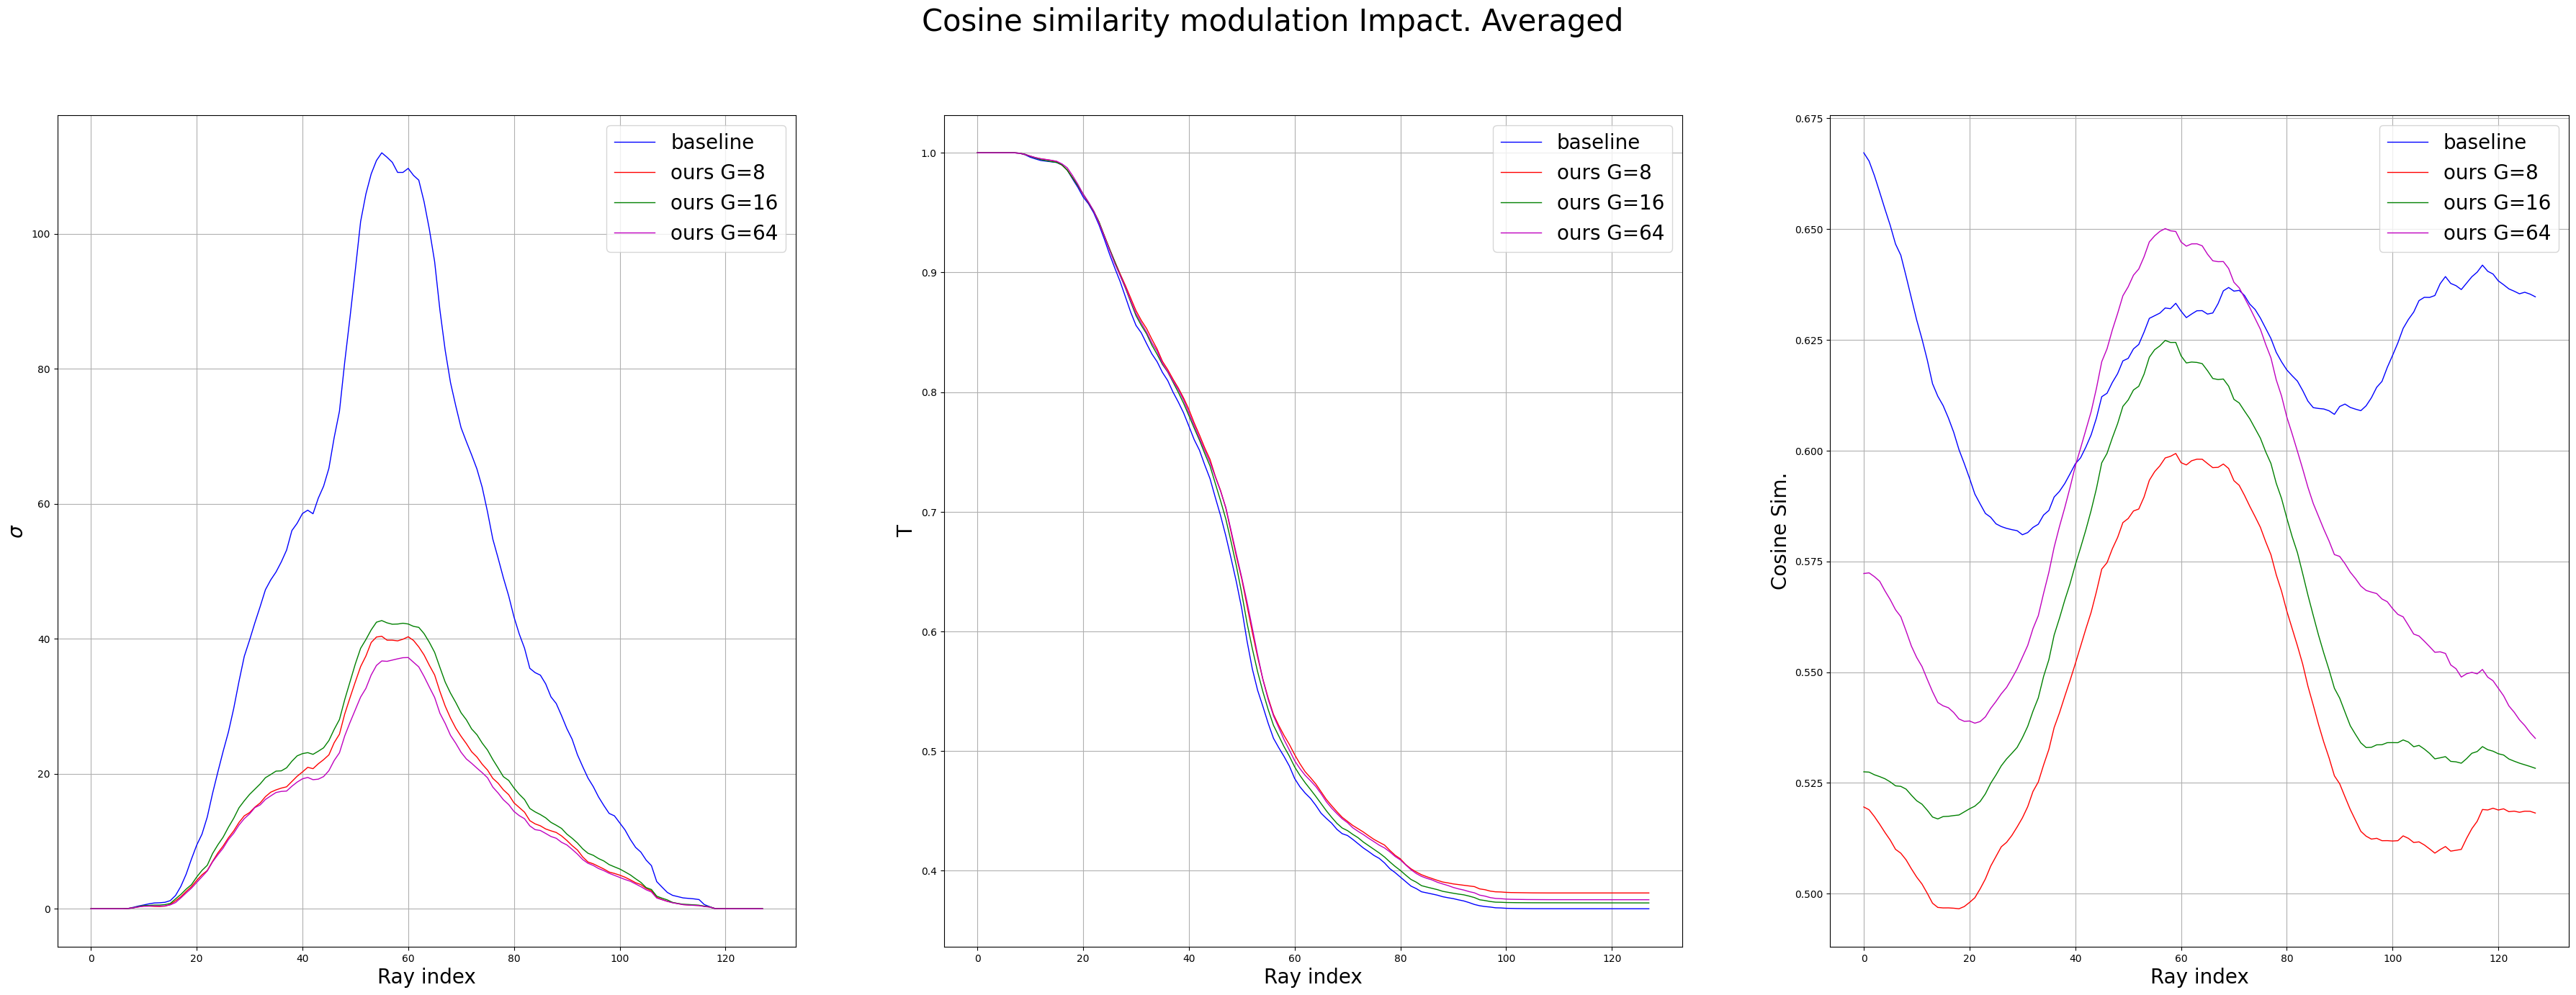

In [32]:
fig, ax1 = plt.subplots(1, 3, figsize=(45, 15))


ax1[0].grid()
ax1[1].grid()
ax1[2].grid()

fig.suptitle('Cosine similarity modulation Impact. Averaged',fontsize=30)

ax1[0].set_xlabel('Ray index', fontsize=20)
ax1[0].set_ylabel(r'$\sigma$', fontsize=20)
ax1[1].set_xlabel('Ray index', fontsize=20)
ax1[1].set_ylabel('T', fontsize=20)
ax1[2].set_xlabel('Ray index', fontsize=20)
ax1[2].set_ylabel('Cosine Sim.', fontsize=20)


ax1[0].plot([i for i in range(nb_sampled_points_on_rays)],density, linewidth=1, alpha=1, label='baseline',color="b")
ax1[0].plot([i for i in range(nb_sampled_points_on_rays)],density_cosineG8, linewidth=1, alpha=1, label='ours G=8',color="r")
ax1[0].plot([i for i in range(nb_sampled_points_on_rays)],density_cosineG16, linewidth=1, alpha=1, label='ours G=16',color="g")
ax1[0].plot([i for i in range(nb_sampled_points_on_rays)],density_cosineG64, linewidth=1, alpha=1, label='ours G=64',color="m")



ax1[0].legend(loc="upper right",fontsize=20)

ax1[1].plot([i for i in range(nb_sampled_points_on_rays)],transmittance, linewidth=1,alpha=1,label='baseline',color="b")
ax1[1].plot([i for i in range(nb_sampled_points_on_rays)],transmittance_cosineG8, linewidth=1,alpha=1,label='ours G=8',color="r")
ax1[1].plot([i for i in range(nb_sampled_points_on_rays)],transmittance_cosineG16, linewidth=1,alpha=1,label='ours G=16',color="g")
ax1[1].plot([i for i in range(nb_sampled_points_on_rays)],transmittance_cosineG64, linewidth=1,alpha=1,label='ours G=64',color="m")



ax1[1].legend(loc="upper right",fontsize=20)


ax1[2].plot([i for i in range(nb_sampled_points_on_rays)],cosine_sim, linewidth=1, alpha=1,label='baseline',color="b")
ax1[2].plot([i for i in range(nb_sampled_points_on_rays)],cosine_sim_cosineG8, linewidth=1, alpha=1,label='ours G=8',color="r")
ax1[2].plot([i for i in range(nb_sampled_points_on_rays)],cosine_sim_cosineG16, linewidth=1, alpha=1,label='ours G=16',color="g")
ax1[2].plot([i for i in range(nb_sampled_points_on_rays)],cosine_sim_cosineG64, linewidth=1, alpha=1,label='ours G=64',color="m")


ax1[2].legend(loc="upper right",fontsize=20)

plt.show()

#### 2.2 On a single random ray example.

In [75]:
random_ray = np.random.randint(0,nb_rays)

### Baseline
cosine_sim_single_ray = dict_similarities['cossim'][f'rays_{random_ray}'] 
transmittance_single_ray = T[bs_chosen,random_ray,:].detach().cpu().numpy()
density_single_ray = sig[bs_chosen,random_ray,:].detach().cpu().numpy()


### Ours - G=8 
cosine_sim_single_ray_cosineG8 = dict_similarities_cosineG8['cossim'][f'rays_{random_ray}'] 
transmittance_single_ray_cosineG8 = T_cosineG8[bs_chosen,random_ray,:].detach().cpu().numpy()
density_single_ray_cosineG8 = sig_cosineG8[bs_chosen,random_ray,:].detach().cpu().numpy()


### Ours - G=16
cosine_sim_single_ray_cosineG16 = dict_similarities_cosineG16['cossim'][f'rays_{random_ray}'] 
transmittance_single_ray_cosineG16 = T_cosineG16[bs_chosen,random_ray,:].detach().cpu().numpy()
density_single_ray_cosineG16 = sig_cosineG16[bs_chosen,random_ray,:].detach().cpu().numpy()


### Ours - G=64
cosine_sim_single_ray_cosineG64 = dict_similarities_cosineG64['cossim'][f'rays_{random_ray}'] 
transmittance_single_ray_cosineG64 = T_cosineG64[bs_chosen,random_ray,:].detach().cpu().numpy()
density_single_ray_cosineG64 = sig_cosineG64[bs_chosen,random_ray,:].detach().cpu().numpy()

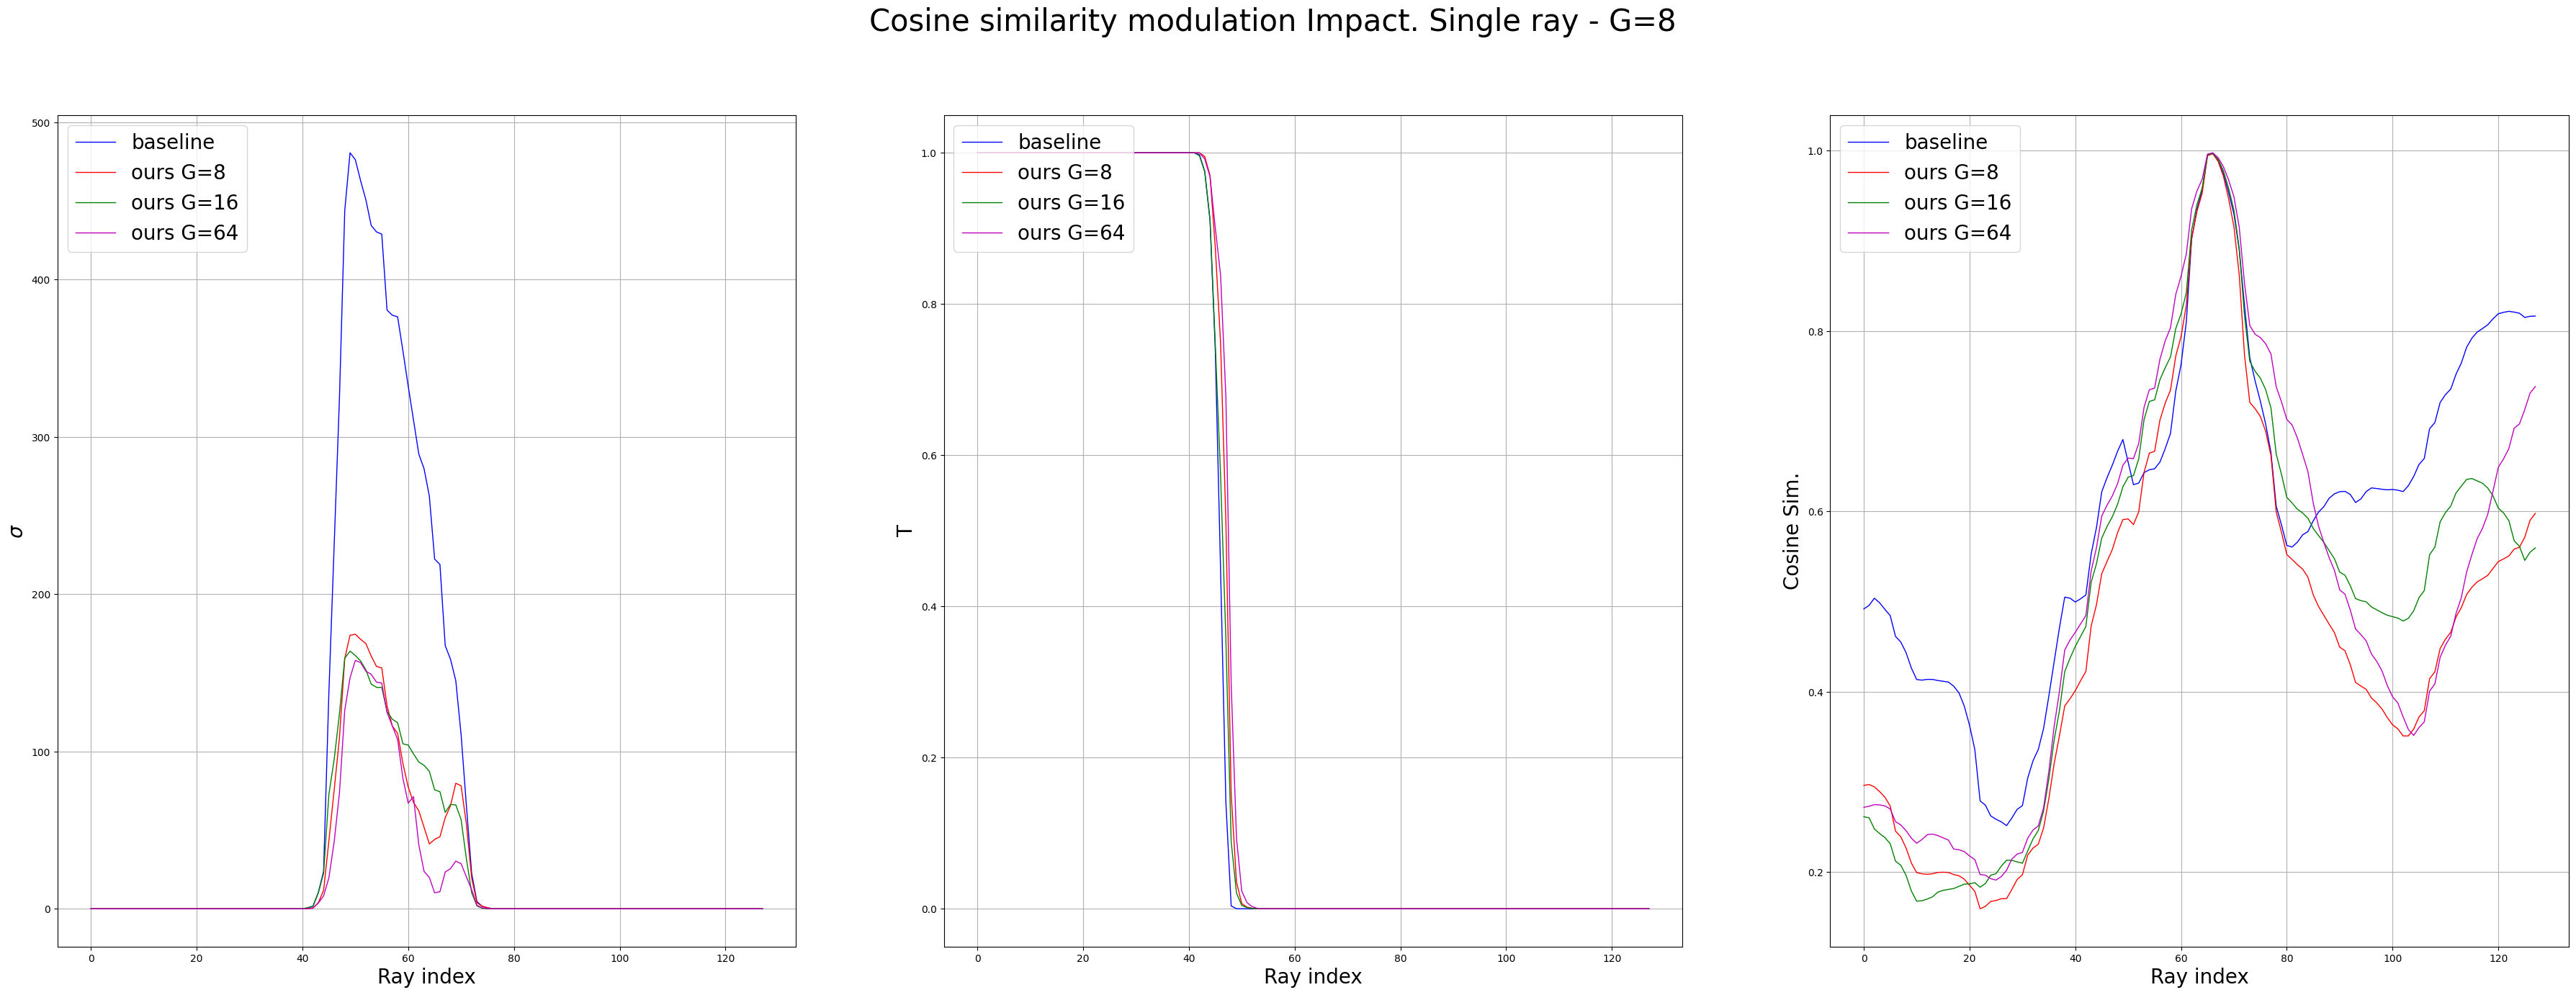

In [76]:
fig, ax1 = plt.subplots(1, 3, figsize=(45, 15))


ax1[0].grid()
ax1[1].grid()
ax1[2].grid()

fig.suptitle('Cosine similarity modulation Impact. Single ray - G=8',fontsize=30)

ax1[0].set_xlabel('Ray index', fontsize=20)
ax1[0].set_ylabel(r'$\sigma$', fontsize=20)
ax1[1].set_xlabel('Ray index', fontsize=20)
ax1[1].set_ylabel('T', fontsize=20)
ax1[2].set_xlabel('Ray index', fontsize=20)
ax1[2].set_ylabel('Cosine Sim.', fontsize=20)


ax1[0].plot([i for i in range(nb_sampled_points_on_rays)],density_single_ray, linewidth=1, alpha=1, label='baseline',color="b")
ax1[0].plot([i for i in range(nb_sampled_points_on_rays)],density_single_ray_cosineG8, linewidth=1, alpha=1, label='ours G=8',color="r")
ax1[0].plot([i for i in range(nb_sampled_points_on_rays)],density_single_ray_cosineG16, linewidth=1, alpha=1, label='ours G=16',color="g")
ax1[0].plot([i for i in range(nb_sampled_points_on_rays)],density_single_ray_cosineG64, linewidth=1, alpha=1, label='ours G=64',color="m")


ax1[0].legend(loc="upper left",fontsize=20)

ax1[1].plot([i for i in range(nb_sampled_points_on_rays)],transmittance_single_ray, linewidth=1,alpha=1,label='baseline',color="b")
ax1[1].plot([i for i in range(nb_sampled_points_on_rays)],transmittance_single_ray_cosineG8, linewidth=1,alpha=1,label='ours G=8',color="r")
ax1[1].plot([i for i in range(nb_sampled_points_on_rays)],transmittance_single_ray_cosineG16, linewidth=1,alpha=1,label='ours G=16',color="g")
ax1[1].plot([i for i in range(nb_sampled_points_on_rays)],transmittance_single_ray_cosineG64, linewidth=1,alpha=1,label='ours G=64',color="m")


ax1[1].legend(loc="upper left",fontsize=20)


ax1[2].plot([i for i in range(nb_sampled_points_on_rays)],cosine_sim_single_ray, linewidth=1, alpha=1,label='baseline',color="b")
ax1[2].plot([i for i in range(nb_sampled_points_on_rays)],cosine_sim_single_ray_cosineG8, linewidth=1, alpha=1,label='ours G=8',color="r")
ax1[2].plot([i for i in range(nb_sampled_points_on_rays)],cosine_sim_single_ray_cosineG16, linewidth=1, alpha=1,label='ours G=16',color="g")
ax1[2].plot([i for i in range(nb_sampled_points_on_rays)],cosine_sim_single_ray_cosineG64, linewidth=1, alpha=1,label='ours G=64',color="m")


ax1[2].legend(loc="upper left",fontsize=20)

plt.show()

#### 1.2 Get projected ray on the first slice of F for a single instance (with a single ray). 

In [40]:
ray_idx = np.random.randint(nb_rays)
bs_chosen = np.random.randint(bs)


### 1. Consider the uv rendered coord. of a single ray and its symmetric. 
uv_single_ray = uv[bs_chosen,ray_idx,:]
uv_symm_single_ray = uv_sym[bs_chosen,ray_idx,:]

x,y  = renormalize_feature(uv_single_ray,H_F,W_F)
x_s,y_s = renormalize_feature(uv_symm_single_ray,H_F,W_F)

### 2. Extract F0 and make it as an RGB image on 3 channels for illustrative purpose. 
F0 = F[bs_chosen,0,:,:].squeeze().detach().cpu().numpy()
F0 = np.stack((F0,)*3, axis=-1)  

### 3. Get the corresponding source image Is that was sampled. 
img_src = rearrange(src_imgs[bs_chosen,:].squeeze(), ' c h w -> h w c')
Is = np_from_tensor(img_src)

### 4. Retrieve the corresponding target Image It and the corresponding pixel that was sampled. 
view_idx_tgt = ray_batch['select_inds'][bs_chosen][ray_idx]//(128*128)
img_tgt = rearrange(tgt_imgs[bs_chosen,view_idx_tgt].squeeze(), 'c h w -> h w c')
It = np_from_tensor(img_tgt)

raw_pixs = ray_batch['pixs'][bs_chosen]
sampled_view = raw_pixs[ray_idx,0]
pix_tgt = raw_pixs[ray_idx,1:].numpy()

/tmp/ipykernel_362/1157353001.py:20: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  view_idx_tgt = ray_batch['select_inds'][bs_chosen][ray_idx]//(128*128)


#### 1.3 Ensure it exists some 3D points pair that share similar projected feature on F.  
Considering a single target ray that would be sampled, get consideration for the 64 3D points that were drawn along this ray. 
1. Compute their symmetric counter-parter according to M. 
2. For each pair of points, compute their corresponding feature. 
3. Define and compute a feature-similarity for each pair, and show in which extent their share similar semantic content on the image. 

In [41]:
list_feature_norm = []
for i in range(nb_sampled_points_on_rays):
    
    f = f_uv[bs_chosen,ray_idx,i,:]
    fs = f_uv_sym[bs_chosen,ray_idx,i,:]
    
    diff_feature = torch.linalg.norm(f-fs)
    list_feature_norm.append(diff_feature.cpu().detach().numpy())


min_ray_index = np.argmin(list_feature_norm) # Get the sample that minimize f_uv - f_uv_sym
max_ray_index = np.argmax(list_feature_norm) # Get the sample that maximize f_uv - f_uv_sym

dict_coord = get_min_max_pix_loc(min_ray_index,max_ray_index,x,y,x_s,y_s)

is_same_min_location = ((dict_coord['ymin'] ==dict_coord['ymin_s']) and (dict_coord['xmin'] == dict_coord['xmin_s']))

#### 1.5 Plot 

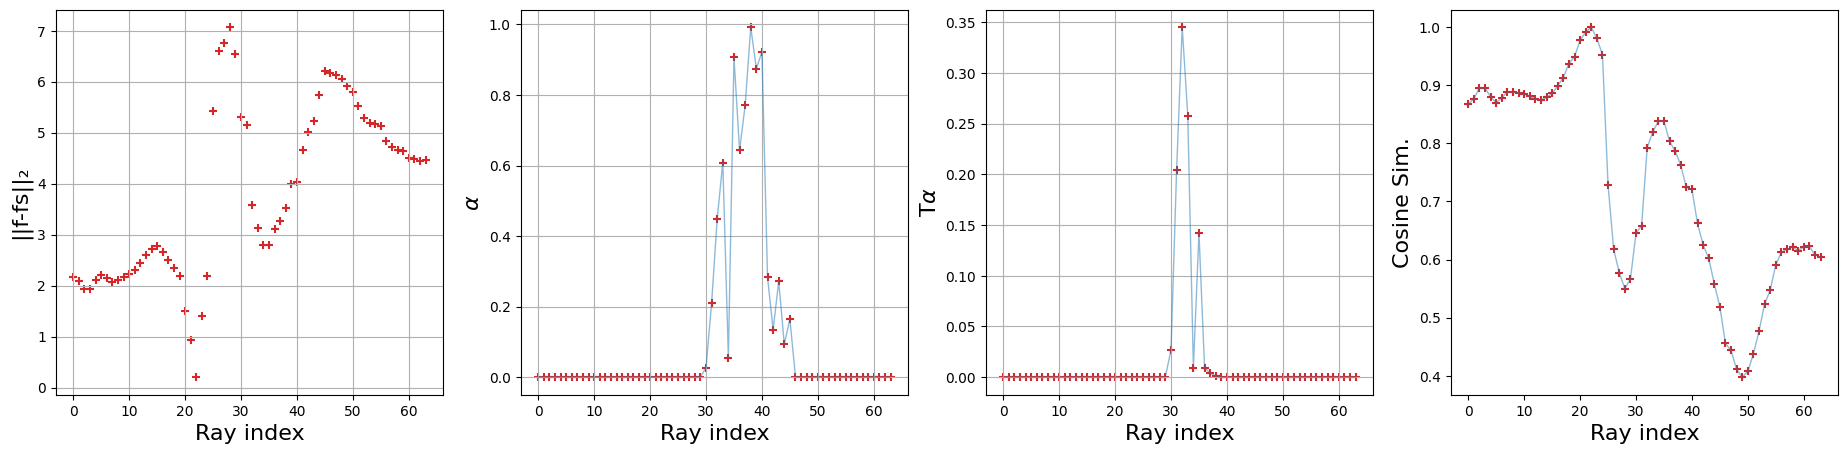

Minimal ray index found: 22
Maximal ray index found: 28


In [50]:
w = weights[bs_chosen,ray_idx,:].detach().cpu().numpy()
a = alpha[bs_chosen,ray_idx,:].detach().cpu().numpy()

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(23, 5))

ax1.grid()
ax2.grid()
ax3.grid()

ax1.set_xlabel('Ray index', fontsize=16)
ax1.set_ylabel('||f-fs||\u2082', fontsize=16)
ax2.set_xlabel('Ray index', fontsize=16)
ax2.set_ylabel(r'$\alpha$', fontsize=16)
ax3.set_xlabel('Ray index', fontsize=16)
ax3.set_ylabel(r'T$\alpha$', fontsize=16)
ax4.set_xlabel('Ray index', fontsize=16)
ax4.set_ylabel('Cosine Sim.', fontsize=16)


ax1.scatter([i for i in range(64)],list_feature_norm,marker = '+',c='#d62728')
ax2.scatter([i for i in range(64)],a,marker = '+',c='#d62728')
ax2.plot([i for i in range(64)],a, linewidth=1, alpha=0.5)
ax3.scatter([i for i in range(64)],w,marker = '+',c='#d62728')
ax3.plot([i for i in range(64)],w, linewidth=1, alpha=0.5)
ax4.scatter([i for i in range(64)],cossim,marker = '+',c='#d62728')
ax4.plot([i for i in range(64)],cossim, linewidth=1, alpha=0.5)

plt.show()

print(f'Minimal ray index found: {min_ray_index}') 
print(f'Maximal ray index found: {max_ray_index}') 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of valid sample: 64
Number of symmetric valid sample: 64


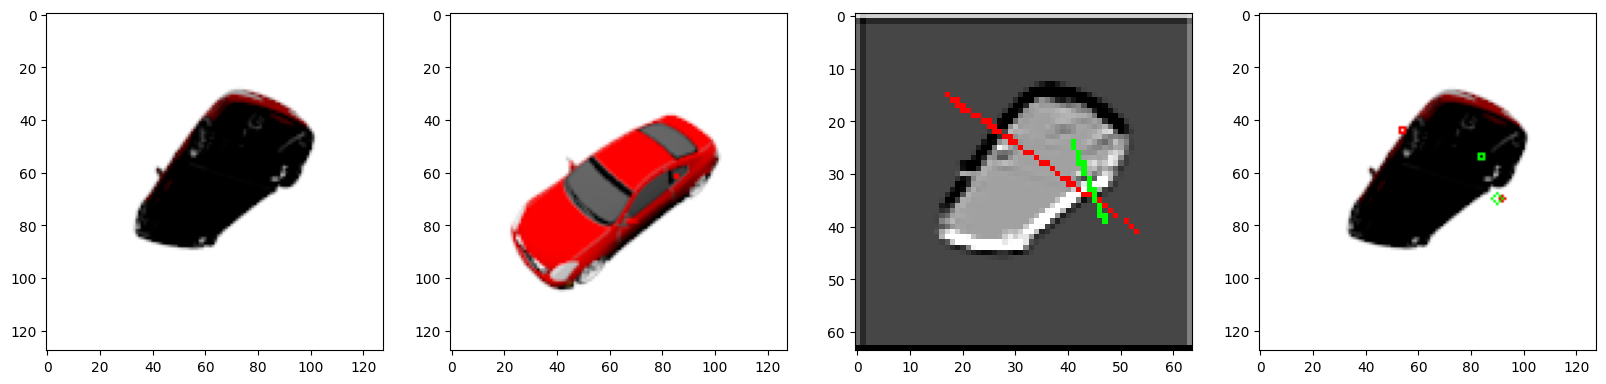

In [31]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 10))

# Draw all required informations on the source, target images and F0
Is_b = draw_loc_on_Is(Is,dict_coord,is_same_min_location)
It_b = draw_sampled_pixel_on_It(It,pix_tgt)
F0_b = draw_projected_ray_on_F0(x,y,x_s,y_s,F0,nb_sampled_points_on_rays)

ax1.imshow(Is)
ax2.imshow(It_b)
ax3.imshow(F0_b,cmap='gray')
ax4.imshow(Is_b)

plt.show()

In [19]:
import json 
import numpy as np 

f = open('/root/SymmNeRF-baseline/logs/evaluation/cosine_sim_exp/results.json')
data = json.load(f)

In [20]:
baseline_psnr = np.mean([float(x) for x in data['model_a']['psnr']])
cosine_psnr = np.mean([float(x) for x in data['model_b']['psnr']])

baseline_ssim = np.mean([float(x) for x in data['model_a']['ssim']])
cosine_ssim = np.mean([float(x) for x in data['model_b']['ssim']])

baseline_lpips = np.mean([float(x) for x in data['model_a']['lpips']])
cosine_lpips = np.mean([float(x) for x in data['model_b']['lpips']])


In [21]:
print(baseline_psnr,cosine_psnr)
print(baseline_ssim,cosine_ssim)
print(baseline_lpips,cosine_lpips)

22.96334152890901 23.022797675358063
0.896886693426 0.897977150502
0.10691800807900727 0.10486490168273449


In [24]:
print(len([float(x) for x in data['model_a']['psnr']]))

5000


In [14]:
psnr_baseline = [float(x) for x in data['model_a']['psnr']]
psnr_cosine = [float(x) for x in data['model_b']['psnr']]


In [16]:
delta_psnr = [x-y for (x,y) in zip(psnr_cosine, psnr_baseline)]

In [18]:
print(np.argmax(delta_psnr))

141


### Make sure both tensors are equal between our implementation and the SNES one. 

#### Compare the symetry computation between our method and SNES architecture. 

In [22]:
import torch 
import torch.nn.functional as F

M_snes = torch.eye(4).to(pts.device)
M_ours = torch.eye(3).to(pts.device)


M_snes[0,0] *= -1.
M_ours[0,0] *= -1.


rays_o = torch.reshape(rays_o, (-1,3))
rays_d = torch.reshape(rays_d,(-1,3))
z_vals = torch.reshape(z_vals,(-1,64))

viewdirs = torch.reshape(viewdirs,(-1,3))

#pts_1 = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None] 
pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., :, None]

def snes_apply_symmetry_transform(x,M, is_dir = False):
    
    x = x.reshape(-1,3)
    pad_val = 0.0 if is_dir else 1.0 # 0 for directions, 1 for points
    x = F.pad(x, (0, 1), mode='constant', value=pad_val) # homogenise points
    
    return torch.einsum('...ij,...j->...i', M, x)[..., :3]

def get_symmetric_points(x,M):
    
    xyz = torch.reshape(x, [x.shape[0], -1, pts.shape[-1]])
    pts_s = (M @ xyz.unsqueeze(-1))[..., 0]
    pts_s = torch.reshape(pts_s,(-1,3))
  
    return pts_s

def get_symmetric_directions(viewdirs,M):
    
    return (M @ viewdirs.unsqueeze(-1))[..., 0]


### Compute both the points and direction symmetry. 
pts_snes_symm = snes_apply_symmetry_transform(pts,M_snes,is_dir = False)
pts_ours_symm = get_symmetric_points(pts,M_ours)

viewdirs_snes_symm = snes_apply_symmetry_transform(viewdirs,M_snes,is_dir = True)
viewdirs_ours_symm = get_symmetric_directions(viewdirs,M_ours)

In [23]:
print(f'Both symmetric pts tensors are equal: {torch.equal(pts_snes_symm,pts_ours_symm)}')
print(f'Both symmetric viewing directions are equal: {torch.equal(viewdirs_snes_symm,viewdirs_ours_symm)}')

Both symmetric pts tensors are equal: True
Both symmetric viewing directions are equal: True
